# Load Environment

In [1]:
import time
import logging
import os
import glob
import sys
from sys import stdout
from collections import deque
import copy
from vis import vis_paths

# import gym
import numpy as np
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# from torch.utils.tensorboard import SummaryWriter

import cv2
import PIL
import numpy as np
import matplotlib.pyplot as plt
from mlagents.envs.environment import UnityEnvironment

import imageio

# set logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# writer = SummaryWriter()

# env_name = 'sep_28'
# env_name = 'oct_22'
# env_name = 'dec_15'
env_name = 'dec_15_small'
# env_name = '1219_masterpiece'
# env_name = '1224'
path = "C:/data/ml-agents-old/scripts/envs/{}/Unity Environment.exe".format(env_name)
# env = UnityEnvironment(file_name="./envs/%s/%s.x86_64" % (env_name, env_name), worker_id=1, seed=1, no_graphics=False)
env = UnityEnvironment(file_name=path, worker_id=0, seed=1, no_graphics=False)
# envs = list(range(10))
# for i in range(10):
#     envs[i] = UnityEnvironment(file_name=path, worker_id=i, seed=1, no_graphics=False)

# import inspect
# inspect.getfullargspec(UnityEnvironment)

INFO:mlagents.envs:
'StationAcademy' started successfully!
Unity Academy name: StationAcademy
        Reset Parameters : {}


# Get environment info

INFO:mlagents.envs:Connected new brain:
Unity brain name: hbf-agent
        Number of Visual Observations (per agent): 2
        Camera Resolutions: ['CameraResolution(84, 84, 1)', 'CameraResolution(84, 84, 3)']
        Vector Observation space size (per agent): 9
        Vector Action space type: discrete
        Vector Action space size (per agent): [2, 3]
        Vector Action descriptions: 
INFO:root:Shape of image: (84, 84, 3)


brain_name hbf-agent
camera_resolutions [CameraResolution(height=84, width=84, num_channels=1), CameraResolution(height=84, width=84, num_channels=3)]
number_visual_observations 2
vector_action_descriptions []
vector_action_space_size [2, 3]
vector_action_space_type discrete
vector_observation_space_size 9


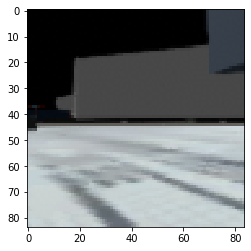

In [2]:
env.step()
default_brain = env.external_brain_names[0]
brain = env.brains[default_brain]
env_info = env.reset(train_mode=True)[default_brain]
print('brain_name', brain.brain_name)
print('camera_resolutions', brain.camera_resolutions)
print('number_visual_observations', brain.number_visual_observations)
print('vector_action_descriptions', brain.vector_action_descriptions)
print('vector_action_space_size', brain.vector_action_space_size)
print('vector_action_space_type', brain.vector_action_space_type)
print('vector_observation_space_size', brain.vector_observation_space_size)

# examine the visual space
img_rgb = np.asarray(env_info.visual_observations[1][0])
imgplt = plt.imshow(img_rgb)
height, width, channel = img_rgb.shape
logger.info('Shape of image: %s' % str(img_rgb.shape))

INFO:root:Shape of image: (84, 84)


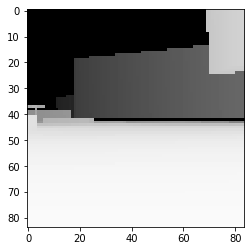

In [3]:
img_d = np.asarray(env_info.visual_observations[0][0])[:,:,0]
imgplt = plt.imshow(img_d, cmap='gray', vmin=0, vmax=1)
logger.info('Shape of image: %s' % str(img_d.shape))

In [4]:
env_info = env.reset(train_mode=True)[default_brain]

## -643.35f, -1.8f, 194.35f
## array([-643.86761475,   -2.58462143,  196.28186035])

In [5]:
env_info.vector_observations[0][-3:][0]

-641.5555419921875

In [6]:
env_info = env.step([0, 0])[default_brain]

In [7]:
env_info.vector_observations[0][-3:]

array([-641.55554199,   -2.59306836,  203.22554016])

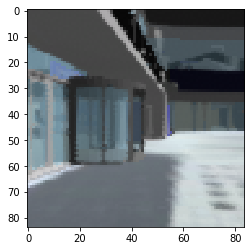

In [8]:
img_rgb = np.asarray(env_info.visual_observations[1][0])
imgplt = plt.imshow(img_rgb)


In [9]:
# from random import randint

# a = []
# for i in range(500):
#     env_info = env.step([randint(0, 1), randint(0, 2)])[default_brain]
# #     print(randint(0, 1), randint(0, 2))
#     a.append([env_info.vector_observations[0][-3:][0], env_info.vector_observations[0][-3:][1], env_info.vector_observations[0][-3:][2]])
#     print(str(i), env_info.vector_observations[0][-3:])

In [10]:
import tensorflow as tf
import numpy as np
import sys
import time
import scipy.misc
import scipy.signal
import pickle

import config
import network

class Agent():
    def __init__(self, name, trainer, global_episode, model_path, env, brain_name):
        self.name = name
        self.trainer = trainer
        self.global_episode = global_episode
        self.summary_writer = tf.summary.FileWriter('./log/' + name)
        self.network = network.Network(name, trainer) # local network
        from_var = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'global')
        to_var = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, name)
        self.copy_network = [b.assign(a) for a, b in zip(from_var, to_var)] # op to sync from global network
        self.model_path = model_path
        self.brain_name = brain_name
        self.env = env
        self.env_info = self.env.reset(train_mode=True)[brain_name]
    
    # static function to save frame during training
    def make_gif(images, fname, duration=2, true_image=False, salience=False, salIMGS=None):
        import moviepy.editor as mpy
        def make_frame(t):
            try:
                x = images[int(len(images)/duration*t)]
            except:
                x = images[-1]
            if true_image:
                return x.astype(np.uint8)
            else:
                return ((x+1)/2*255).astype(np.uint8)
        
        def make_mask(t):
            try:
                x = salIMGS[int(len(salIMGS)/duration*t)]
            except:
                x = salIMGS[-1]
            return x

        clip = mpy.VideoClip(make_frame, duration=duration)
        if salience == True:
            mask = mpy.VideoClip(make_mask, ismask=True,duration= duration)
            clipB = clip.set_mask(mask)
            clipB = clip.set_opacity(0)
            mask = mask.set_opacity(0.1)
            mask.write_gif(fname, fps = len(images) / duration,verbose=False)
        else:
            clip.write_gif(fname, fps = len(images) / duration,verbose=False)

    # static function
    def resize_image(image):
        image = image.astype(np.float32) / 255.0
        return image
        #return scipy.misc.imresize(image, [84, 84])
        
    # !!!!!
    # stack sliding windows into discret 1d array
    def window_stack(self, a, stepsize=10, trim=2):
        a = a[trim:a.shape[0]-trim, trim:a.shape[1]-trim]
        b = []
        for i in range(int(a.shape[0] / stepsize)):
            for j in range(int(a.shape[1] / stepsize)):
                b.append(np.mean(a[i*stepsize:i*stepsize+stepsize,j*stepsize:j*stepsize+stepsize]))

        b = np.array(b)
        # map to [0, 8) int
        b = b * 7
        b = b.astype(int)

        return b

    def discount(x, gamma):
        return scipy.signal.lfilter([1], [1, -gamma], x[::-1], axis=0)[::-1]

    def train(self, train_buffer, sess, boot_value):
        train_buffer = np.array(train_buffer)
        # unroll from train_buffer
        input_image = np.array(train_buffer[:, 0].tolist())
        aux_action = np.array(train_buffer[:, 1].tolist())
        aux_reward = np.array(train_buffer[:, 2:3].tolist())
        aux_velocity = np.array(train_buffer[:, 3].tolist())
        action = train_buffer[:, 4]
        reward = train_buffer[:, 5]
        value = train_buffer[:, 6]
        depth_pred = train_buffer[:, 7] # <- ?
        true_depth = np.array(train_buffer[:, 8].tolist())

        reward_plus = np.asarray(reward.tolist() + [boot_value])
        disc_reward = Agent.discount(reward_plus, config.GAMMA)[:-1]
        value_plus = np.asarray(value.tolist())
        #advantage = Agent.discount(reward + config.GAMMA*value_plus[1:] - value_plus[:-1], config.GAMMA)
        advantage = disc_reward - value_plus
        vl, pl, el, dl, dl2, gradn, _ , d_tmp= sess.run([self.network.value_loss,
            self.network.policy_loss,
            self.network.entropy_loss,
            self.network.depth_loss,
            self.network.depth_loss2,
            self.network.gradient_norm,
            self.network.apply_gradient, self.network.depth_loss_], feed_dict={
                self.network.input_image: input_image,
                self.network.input_action: aux_action,
                self.network.input_reward: aux_reward,
                self.network.input_velocity: aux_velocity,
                self.network.true_value: disc_reward,
                self.network.advantage: advantage,
                self.network.action: action,
                self.network.true_depth: true_depth,
                self.network.lstm1_state_c_in: self.train_lstm1_state_c,
                self.network.lstm1_state_h_in: self.train_lstm1_state_h,
                self.network.lstm2_state_c_in: self.train_lstm2_state_c,
                self.network.lstm2_state_h_in: self.train_lstm2_state_h
            })
        sys.stdout.flush()
        return vl, pl, el, dl, dl2, gradn, _

    def get_action(self, action):
        move_forward  = action // 3
        rotate = action % 3
        return [move_forward, rotate]

    def get_vel(self, prev_coord, coord, action_transformed):
        if action_transformed[0] == 0:
            distance = np.linalg.norm(coord-prev_coord)
            # cos 15 degrees, corresponding to turning angle in unity
            if action_transformed[1] == 0:
                result = [0.96*distance, (coord[1]-prev_coord[1]), -0.26*distance, 0, -15, 0]
            if action_transformed[1] == 1:
                # cos 15 degrees, corresponding to turning angle in unity
                result = [distance, (coord[1]-prev_coord[1]), 0, 0, 0, 0]
            if action_transformed[1] == 2:
                result = [0.96*distance, (coord[1]-prev_coord[1]), 0.26*distance, 0, 15, 0]

        elif action_transformed[0] == 1:
            if action_transformed[1] == 0:
                result = [0, 0, 0, 0, -15, 0]
            if action_transformed[1] == 1:
                # cos 15 degrees, corresponding to turning angle in unity
                result = [0, 0, 0, 0, 0, 0]
            if action_transformed[1] == 2:
                result = [0, 0, 0, 0, 15, 0]
        else:
            assert 0, "action_transformed's first element is unknown"

        result = np.array(result)
        return result

    def run(self, sess, trainer, saver, coordinator):
        print('starting agent:', self.name)
        sys.stdout.flush()
        with sess.as_default(), sess.graph.as_default():
            while not coordinator.should_stop():
                sess.run(self.global_episode.assign_add(1))
                print('episode:', sess.run(self.global_episode))
                sys.stdout.flush()
                
                ep = sess.run(self.global_episode)
                ep_reward = 0
                ep_step = 0
                ep_start_time = time.time()

                sess.run(self.copy_network)
                self.train_buffer = []
                frame_buffer = []
                running = True

                # !!!!!!
                # self.game.reset()
                # rgb, prev_d = self.game.frame()
                rgb = np.asarray(self.env_info.visual_observations[1][0])
                prev_d = self.window_stack(np.asarray(self.env_info.visual_observations[0][0]))

                frame_buffer.append(rgb * 255)
                # rgb = Agent.resize_image(rgb)
                prev_act_idx = 0
                prev_reward = 0
                prev_vel = np.array([0.0]*6)
                prev_coord = self.env_info.vector_observations[0][-3:]

                self.lstm1_state_c, self.lstm1_state_h, self.lstm2_state_c, self.lstm2_state_h = self.network.lstm1_init_state_c, self.network.lstm1_init_state_h,self.network.lstm2_init_state_c,self.network.lstm2_init_state_h
                
                self.env_info = self.env.reset(train_mode=True)[self.brain_name]
                print('initial position:({:.2f} {:.2f} {:.2f})'.format(self.env_info.vector_observations[0][-3:][0], 
                                                                       self.env_info.vector_observations[0][-3:][1],
                        self.env_info.vector_observations[0][-3:][2]))
                # !!!!!!
                # while self.game.running():
                ep_step_max = 1000
                positions = []
                while True:
                    if len(self.train_buffer)==0:
                        self.train_lstm1_state_h = self.lstm1_state_h
                        self.train_lstm1_state_c = self.lstm1_state_c
                        self.train_lstm2_state_h = self.lstm2_state_h
                        self.train_lstm2_state_c = self.lstm2_state_c
                    act_prob, pred_value, depth_pred, self.lstm1_state_c, self.lstm1_state_h, self.lstm2_state_c, self.lstm2_state_h = sess.run([self.network.policy,
                        self.network.value, self.network.depth_pred,
                        self.network.lstm1_state_c_out, 
                        self.network.lstm1_state_h_out, 
                        self.network.lstm2_state_c_out, 
                        self.network.lstm2_state_h_out]
                        , 
                        feed_dict={self.network.input_image: [rgb], 
                        self.network.input_action: [prev_act_idx], 
                        self.network.input_reward: [[prev_reward]], 
                        self.network.input_velocity: [prev_vel],
                        self.network.lstm1_state_c_in:self.lstm1_state_c,
                        self.network.lstm1_state_h_in:self.lstm1_state_h,
                        self.network.lstm2_state_c_in:self.lstm2_state_c,
                        self.network.lstm2_state_h_in:self.lstm2_state_h
                    })
                    
                    self.action_visualize = act_prob
                    action = np.random.choice(act_prob[0], p=act_prob[0])
                    action_idx = np.argmax(act_prob==action)
                    
                    # !!!!!!
                    # rgb_next, d, vel, reward, running = self.game.step(action_idx)
                    action_transformed = self.get_action(action_idx)
                    self.env_info = self.env.step(action_transformed)[self.brain_name] # send the action to the environment
                    rgb_next = np.asarray(self.env_info.visual_observations[1][0])  # get the next state
                    d = self.window_stack(np.asarray(self.env_info.visual_observations[0][0]))

                    reward = self.env_info.rewards[0]                   # get the reward
                    done = self.env_info.local_done[0]                  # see if episode has finished
                    coord = self.env_info.vector_observations[0][-3:]

                    # !!!!!!
                    # only an estimation, get velocity from previous and current coordination, and action vector
                    vel = self.get_vel(prev_coord, coord, action_transformed)
                    
                    sys.stdout.write('\r episode:{}, step: {}, position:({:.2f} {:.2f} {:.2f}), score:{:.2f}, action:{}'.format(self.name, ep_step,
                        self.env_info.vector_observations[0][-3:][0], self.env_info.vector_observations[0][-3:][1],
                        self.env_info.vector_observations[0][-3:][2], ep_reward, str(action_idx)))
                    sys.stdout.flush()
                    
                    positions.append([self.env_info.vector_observations[0][-3:][0], 
                                     self.env_info.vector_observations[0][-3:][1], 
                                     self.env_info.vector_observations[0][-3:][2]])
                    
                    self.train_buffer.append([rgb, prev_act_idx, prev_reward, prev_vel, action_idx, 
                                         reward, pred_value[0][0], depth_pred, prev_d])

                    ep_reward += reward
                    ep_step += 1
                    
                    running = not ((ep_step >= ep_step_max) or done)

                    if running:
                        if ep%config.SAVE_PERIOD==0:
                            frame_buffer.append(rgb_next * 255)
                        # rgb_next = Agent.resize_image(rgb_next)
                        rgb = rgb_next
                    
                    prev_act_idx = action_idx
                    prev_reward = reward
                    prev_vel = vel
                    prev_d = d

                    if len(self.train_buffer)==config.GRADIENT_CHUNK and running:
                        boot_value = sess.run(self.network.value, feed_dict={
                            self.network.input_image: [rgb], 
                            self.network.input_action: [prev_act_idx], 
                            self.network.input_reward: [[prev_reward]], 
                            self.network.input_velocity: [prev_vel],
                            self.network.lstm1_state_c_in:self.lstm1_state_c,
                            self.network.lstm1_state_h_in:self.lstm1_state_h,
                            self.network.lstm2_state_c_in:self.lstm2_state_c,
                            self.network.lstm2_state_h_in:self.lstm2_state_h
                        })
                        vl, pl, el, dl, dl2, gradn, _ = self.train(self.train_buffer, sess, boot_value)
                        self.train_buffer = []
                        sess.run(self.copy_network)
                    if not running:
                        break
                if len(self.train_buffer)>0:
                    vl, pl, el, dl, dl2, gradn, _ = self.train(self.train_buffer, sess, 0.0)
                    self.test1 = [vl, pl, el, dl, dl2, gradn]

                ep_finish_time = time.time()
                print(self.name, 'elapse', str(int(ep_finish_time-ep_start_time)), 'seconds, reward:',ep_reward)
                sys.stdout.flush()

                
                if ep%config.SAVE_PERIOD==0:
                    imgs = np.array(frame_buffer)
                    Agent.make_gif(imgs, './frame/image'+str(ep)+'_'+str(ep_reward)+'.gif', duration=len(imgs)*0.066, true_image=True, salience=False)
                    print('frame saved')
                    sys.stdout.flush()
                

                if ep%config.SAVE_PERIOD==0:
                    saver.save(sess, self.model_path+'/model'+str(ep)+'.cptk')
                    print('model saved')
                    sys.stdout.flush()

                    summary = tf.Summary()
                    summary.value.add(tag='Losses/Policy Loss', simple_value=float(pl))
                    summary.value.add(tag='Losses/Value Loss', simple_value=float(vl))
                    summary.value.add(tag='Losses/Entropy Loss', simple_value=float(el))
                    summary.value.add(tag='Losses/Depth Loss', simple_value=float(dl))
                    summary.value.add(tag='Losses/Depth Loss2', simple_value=float(dl2))
                    summary.value.add(tag='Losses/Gradient Norm', simple_value=float(gradn))
                    summary.value.add(tag='Performance/Reward', simple_value=float(ep_reward))
                    self.summary_writer.add_summary(summary, ep)
                    self.summary_writer.flush()
                    
                if ep%config.SAVE_PERIOD==0:
                    print('save positions')
                    sys.stdout.flush()
                    
                    with open('./positions/'+str(ep), 'wb') as fp:
                        pickle.dump(positions, fp)
                        

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import os
import threading
import sys
import time

import config
import network
# import agent
    
model_path = './model'
frame_path = './frame'
if not os.path.exists(model_path):
    os.makedirs(model_path)
if not os.path.exists(frame_path):
    os.makedirs(frame_path)

with tf.device('cpu:0'):
    global_episode = tf.Variable(0, trainable=False, dtype=tf.int32)
    trainer = tf.train.RMSPropOptimizer(config.LEARNING_RATE, decay=config.DECAY, 
                                        momentum=config.MOMENTUM, epsilon=config.EPSILON)
    master_network = network.Network('global', trainer)
    print('master network created')
    sys.stdout.flush()
    agent_arr = []
    for i in range(config.THREAD):
        agent_arr.append(Agent('thread_'+str(i)+'_'+str(time.time()), trainer, global_episode, 
                               model_path, env, default_brain))
    saver = tf.train.Saver()

with tf.Session() as sess:
    coord = tf.train.Coordinator()
    sess.run(tf.global_variables_initializer())
    # ckpt = tf.train.get_checkpoint_state(model_path)
    # saver.restore(sess, ckpt.model_checkpoint_path)
    thread_arr = []
    for a in agent_arr:
        _ = lambda: a.run(sess, trainer, saver, coord)
        t = threading.Thread(target=(_))
        t.start()
        print('thread started')
        sys.stdout.flush()
        time.sleep(1)
        thread_arr.append(t)
    coord.join(thread_arr)




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


master network created





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


starting agent:thread started 
thread_0_1577222129.9262495
episode: 1
initial position:(-641.56 -2.60 208.23)
 episode:thread_0_1577222129.9262495, step: 999, position:(-688.71 -5.57 172.06), score:0.02, action:4thread_0_1577222129.9262495 elapse 32 seconds, reward: 0.01000022329390049
MoviePy - Building file ./frame/image1_0.01000022329390049.gif with imageio.


frame saved
model saved
save positions
episode: 2
initial position:(-633.02 -5.28 204.69)
 episode:thread_0_1577222129.9262495, step: 999, position:(-611.00 -3.67 138.00), score:0.02, action:3thread_0_1577222129.9262495 elapse 32 seconds, reward: 0.01000022329390049
MoviePy - Building file ./frame/image2_0.01000022329390049.gif with imageio.


frame saved
model saved
save positions
episode: 3
initial position:(-640.69 -3.38 177.17)
 episode:thread_0_1577222129.9262495, step: 999, position:(-694.90 -23.60 119.06), score:-9.99, action:0thread_0_1577222129.9262495 elapse 31 seconds, reward: -9.999999776482582
MoviePy - Building file ./frame/image3_-9.999999776482582.gif with imageio.


frame saved
model saved
save positions
episode: 4
initial position:(-640.69 -23.02 177.17)
 episode:thread_0_1577222129.9262495, step: 999, position:(-654.23 -43.10 123.04), score:-9.99, action:0thread_0_1577222129.9262495 elapse 30 seconds, reward: -9.999999776482582
MoviePy - Building file ./frame/image4_-9.999999776482582.gif with imageio.


frame saved
model saved
save positions
episode: 5
initial position:(-640.69 -42.66 177.17)
 episode:thread_0_1577222129.9262495, step: 999, position:(-708.68 -63.18 98.11), score:-9.99, action:11thread_0_1577222129.9262495 elapse 28 seconds, reward: -9.999999776482582
MoviePy - Building file ./frame/image5_-9.999999776482582.gif with imageio.


frame saved
model saved
save positions
episode: 6
initial position:(-686.20 -62.23 192.00)
 episode:thread_0_1577222129.9262495, step: 999, position:(-701.40 -5.34 180.21), score:-9.99, action:1thread_0_1577222129.9262495 elapse 31 seconds, reward: -9.999999776482582
MoviePy - Building file ./frame/image6_-9.999999776482582.gif with imageio.


frame saved


Instructions for updating:
Use standard file APIs to delete files with this prefix.


model saved
save positions
episode: 7
initial position:(-633.02 -5.14 204.69)
 episode:thread_0_1577222129.9262495, step: 999, position:(-651.40 -15.40 141.37), score:-9.99, action:2thread_0_1577222129.9262495 elapse 31 seconds, reward: -9.999999776482582
MoviePy - Building file ./frame/image7_-9.999999776482582.gif with imageio.


frame saved
model saved
save positions
episode: 8
initial position:(-640.87 -15.14 173.92)
 episode:thread_0_1577222129.9262495, step: 999, position:(-610.03 -3.01 166.06), score:0.02, action:213thread_0_1577222129.9262495 elapse 34 seconds, reward: 0.01000022329390049
MoviePy - Building file ./frame/image8_0.01000022329390049.gif with imageio.


frame saved
model saved
save positions
episode: 9
initial position:(-623.41 -3.06 163.25)
 episode:thread_0_1577222129.9262495, step: 999, position:(-595.95 -4.92 81.01), score:-9.99, action:22thread_0_1577222129.9262495 elapse 37 seconds, reward: -9.999999776482582
MoviePy - Building file ./frame/image9_-9.999999776482582.gif with imageio.


frame saved
model saved
save positions
episode: 10
initial position:(-588.53 -4.60 123.89)
 episode:thread_0_1577222129.9262495, step: 999, position:(-594.61 -4.50 152.19), score:-9.99, action:31thread_0_1577222129.9262495 elapse 33 seconds, reward: -9.999999776482582
MoviePy - Building file ./frame/image10_-9.999999776482582.gif with imageio.


frame saved
model saved
save positions
episode: 11
initial position:(-613.21 -4.32 177.53)
 episode:thread_0_1577222129.9262495, step: 999, position:(-673.25 -4.74 205.33), score:-9.99, action:2thread_0_1577222129.9262495 elapse 31 seconds, reward: -9.999999776482582
MoviePy - Building file ./frame/image11_-9.999999776482582.gif with imageio.


frame saved
model saved
save positions
episode: 12
initial position:(-641.56 -4.79 201.15)
 episode:thread_0_1577222129.9262495, step: 999, position:(-663.25 -5.30 205.93), score:-9.99, action:3thread_0_1577222129.9262495 elapse 31 seconds, reward: -9.999999776482582
MoviePy - Building file ./frame/image12_-9.999999776482582.gif with imageio.


frame saved
model saved
save positions
episode: 13
initial position:(-641.56 -5.31 208.23)
 episode:thread_0_1577222129.9262495, step: 999, position:(-573.98 -3.80 185.96), score:-9.99, action:5thread_0_1577222129.9262495 elapse 32 seconds, reward: -9.999999776482582
MoviePy - Building file ./frame/image13_-9.999999776482582.gif with imageio.


frame saved
model saved
save positions
episode: 14
initial position:(-640.68 -3.80 188.28)
 episode:thread_0_1577222129.9262495, step: 999, position:(-632.09 -12.31 158.03), score:0.02, action:5thread_0_1577222129.9262495 elapse 31 seconds, reward: 0.01000022329390049
MoviePy - Building file ./frame/image14_0.01000022329390049.gif with imageio.


frame saved
model saved
save positions
episode: 15
initial position:(-640.87 -12.19 173.92)
 episode:thread_0_1577222129.9262495, step: 999, position:(-655.36 -31.88 169.10), score:-9.99, action:3thread_0_1577222129.9262495 elapse 31 seconds, reward: -9.999999776482582
MoviePy - Building file ./frame/image15_-9.999999776482582.gif with imageio.


frame saved
model saved
save positions
episode: 16
initial position:(-640.69 -31.81 177.17)
 episode:thread_0_1577222129.9262495, step: 999, position:(-672.00 -51.94 119.14), score:-9.99, action:1thread_0_1577222129.9262495 elapse 29 seconds, reward: -9.999999776482582
MoviePy - Building file ./frame/image16_-9.999999776482582.gif with imageio.


frame saved
model saved
save positions
episode: 17
initial position:(-632.33 -51.44 177.45)
 episode:thread_0_1577222129.9262495, step: 999, position:(-606.61 -9.04 162.10), score:-9.99, action:35thread_0_1577222129.9262495 elapse 30 seconds, reward: -9.999999776482582
MoviePy - Building file ./frame/image17_-9.999999776482582.gif with imageio.


frame saved
model saved
save positions
episode: 18
initial position:(-617.20 -9.05 162.50)
 episode:thread_0_1577222129.9262495, step: 999, position:(-614.76 -15.68 151.62), score:-9.99, action:5thread_0_1577222129.9262495 elapse 31 seconds, reward: -9.999999776482582
MoviePy - Building file ./frame/image18_-9.999999776482582.gif with imageio.


frame saved
model saved
save positions
episode: 19
initial position:(-625.22 -15.67 154.89)
 episode:thread_0_1577222129.9262495, step: 999, position:(-613.85 -8.41 166.85), score:-9.99, action:1thread_0_1577222129.9262495 elapse 32 seconds, reward: -9.999999776482582
MoviePy - Building file ./frame/image19_-9.999999776482582.gif with imageio.


frame saved
model saved
save positions
episode: 20
initial position:(-617.55 -8.42 167.26)
 episode:thread_0_1577222129.9262495, step: 999, position:(-505.40 -6.82 192.75), score:-9.99, action:12thread_0_1577222129.9262495 elapse 31 seconds, reward: -9.999999776482582
MoviePy - Building file ./frame/image20_-9.999999776482582.gif with imageio.


frame saved
model saved
save positions
episode: 21
initial position:(-552.65 -6.80 198.30)
 episode:thread_0_1577222129.9262495, step: 999, position:(-468.48 3.31 60.93), score:0.02, action:11111thread_0_1577222129.9262495 elapse 32 seconds, reward: 0.01000022329390049
MoviePy - Building file ./frame/image21_0.01000022329390049.gif with imageio.


frame saved
model saved
save positions
episode: 22
initial position:(-545.40 3.30 76.80)
 episode:thread_0_1577222129.9262495, step: 949, position:(-439.87 -4.40 54.62), score:-9.49, action:1

### visualize depth vector

In [12]:
train_buffer = np.array(agent_arr[0].train_buffer)

In [13]:
true_depth = np.array(train_buffer[:, 8].tolist())
depth_pred = train_buffer[:, 7]
input_image = np.array(train_buffer[:, 0].tolist())

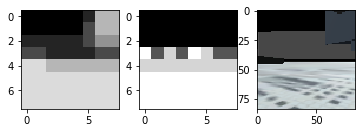

In [19]:
i = 8
plt.subplot(1, 3, 1)
plt.imshow(true_depth[i].reshape(8, 8), cmap='gray', interpolation='nearest', vmin=0, vmax=7)
plt.subplot(1, 3, 2)
plt.imshow(depth_pred[i].reshape(8, 8), cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(input_image[i])
plt.show()

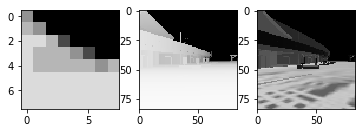

In [20]:
plt.subplot(1, 3, 1)
d = agent_arr[0].window_stack(np.asarray(agent_arr[0].env_info.visual_observations[0][0]))
plt.imshow(d.reshape(8, 8), cmap='gray', interpolation='nearest', vmin=0, vmax=7)
plt.subplot(1, 3, 2)
img_d = np.asarray(agent_arr[0].env_info.visual_observations[0][0])[:,:,0]
plt.imshow(img_d, cmap='gray', vmin=0, vmax=1)
plt.subplot(1, 3, 3)
img_d = np.asarray(agent_arr[0].env_info.visual_observations[1][0])[:,:,0]
plt.imshow(img_d, cmap='gray', vmin=0, vmax=1)
plt.show()

In [21]:
d

array([4, 0, 0, 0, 0, 0, 0, 0, 5, 4, 0, 0, 0, 0, 0, 0, 6, 6, 5, 2, 0, 0,
       0, 0, 6, 5, 5, 5, 4, 2, 0, 0, 6, 5, 5, 5, 5, 5, 4, 5, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])

### visualize action probability

In [22]:
agent_arr[0].action_visualize

array([[1.2160218e-03, 2.5207640e-03, 1.0990636e-02, 9.8242378e-01,
        1.9187059e-03, 9.3012367e-04]], dtype=float32)

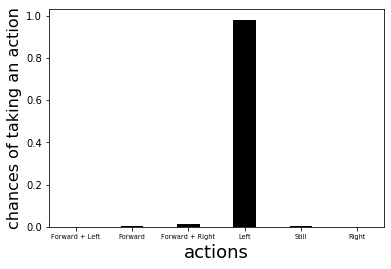

In [23]:
# import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.bar([1,2,3,4,5,6], agent_arr[0].action_visualize[0], color='black', width=0.4)
ax.set_xticklabels(['', 'Forward + Left', 'Forward', 'Forward + Right', 
                    'Left', 'Still', 'Right'], fontsize=6.5)
plt.xlabel('actions', fontsize=18)
plt.ylabel('chances of taking an action', fontsize=16)
plt.show()


In [ ]:
agent_arr[0].env_info.visual_observations[0][0]

In [ ]:
img_d = np.asarray(agent_arr[0].env_info.visual_observations[0][0])[:,:,0]
imgplt = plt.imshow(img_d, cmap='gray', vmin=0, vmax=1)
logger.info('Shape of image: %s' % str(img_d.shape))

# A2C function

In [ ]:
from a2c_ppo_acktr import algo, utils
# from a2c_ppo_acktr.algo import gail
from a2c_ppo_acktr.arguments import get_args
# from a2c_ppo_acktr.envs import make_vec_envs
from a2c_ppo_acktr.model import Policy
from a2c_ppo_acktr.storage import RolloutStorage
# from evaluation import evaluate

observation_space = [3, 300, 300]
action_space = 3

# def a2c_ppo_acktr(env_info, al_type='a2c', gail=False, gail_experts_dir='./gail_experts', 
#                   gail_batch_size=128, gail_epoch=1e5, alpha=0.99, 
#                   gamma=0.99, use_gae=False, gae_lambda=0.95, 
#                   entropy_coef=0.01, value_loss_coef=0.5, max_grad_norm=0.5, 
#                   seed=False, num_processes=1, num_steps=5, ppo_epoch=4, num_mini_batch=32, 
#                   clip_param=0.2, log_interval=10, save_interval=100, eval_interval=None, 
#                   num_env_steps=10e6, env_name='PongNoFrameskip_v4', log_dir='/tmp/gym/', 
#                   save_dir='./trained_models/', no_cuda=False, use_proper_time_limits=False, 
#                   recurrent_policy=False, use_linear_lr_decay=False, cuda=True, cuda_deterministic=True, 
#                   eps=1e-5, lr=7e-4):

# ====== for testing
if True:
    
    n_episodes=1000
    al_type='a2c'
    gail=False
    gail_experts_dir='./gail_experts'
    gail_batch_size=128
    gail_epoch=1e5
    alpha=0.99
    gamma=0.99
    use_gae=False
    gae_lambda=0.95
    entropy_coef=0.01
    value_loss_coef=0.5
    max_grad_norm=0.5
    seed=False
    num_processes=1
    num_steps=1000
    ppo_epoch=4
    num_mini_batch=32
    clip_param=0.2
    log_interval=10
    save_interval=1000
    eval_interval=None
    num_env_steps=10e6
    env_name='vcs_test'
    log_dir='/tmp/vcs/'
    save_dir='./trained_models/'
    no_cuda=False
    use_proper_time_limits=False
    recurrent_policy=False
    use_linear_lr_decay=False
    cuda=True
    cuda_deterministic=True
    eps=1e-5
    lr=7e-4
    
    # load_prev_model=os.path.join(save_dir, al_type, env_name + "_back.pt")
    load_prev_model = None
    
# ====== for testing

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    if cuda and torch.cuda.is_available() and cuda_deterministic:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

    log_dir = os.path.expanduser(log_dir)
    eval_log_dir = log_dir + "_eval"
    utils.cleanup_log_dir(log_dir)
    utils.cleanup_log_dir(eval_log_dir)

    torch.set_num_threads(1)
    device = torch.device("cuda:1" if cuda else "cpu")
    
    actor_critic = Policy(
        observation_space,
        action_space,
        base_kwargs={'recurrent': recurrent_policy})
    
    actor_critic.to(device)
    
    if not load_prev_model is None:
        agent = torch.load(load_prev_model)
        
    # torch.save(model)
    # model = torch.load(PATH)
    
    if al_type == 'a2c':
        agent = algo.A2C_ACKTR(
            actor_critic,
            value_loss_coef,
            entropy_coef,
            lr=lr,
            eps=eps,
            alpha=alpha,
            max_grad_norm=max_grad_norm)
    elif al_type == 'ppo':
        agent = algo.PPO(
            actor_critic,
            clip_param,
            ppo_epoch,
            num_mini_batch,
            value_loss_coef,
            entropy_coef,
            lr=lr,
            eps=eps,
            max_grad_norm=max_grad_norm)
    elif al_type == 'acktr':
        agent = algo.A2C_ACKTR(
            actor_critic, value_loss_coef, entropy_coef, acktr=True)

    rollouts = RolloutStorage(num_steps, num_processes,
                              observation_space, action_space,
                              actor_critic.recurrent_hidden_state_size)

    env_info = env.reset(train_mode=True)[brain_name]
    obs = torch.from_numpy(np.transpose(np.asarray(env_info.visual_observations)[0], (0, 3, 1, 2)))
    reward = [env_info.rewards[0]]                   # get the reward
    done = [env_info.local_done[0]]                  # see if episode has finished
    
    rollouts.obs[0].copy_(obs)
    rollouts.to(device)

    episode_rewards = []

    start = time.time()
    
    positions = []    
    num_updates = n_episodes
    
    for j in range(num_updates):
        
        # out video!!!!
        # out_video = imageio.get_writer('./%s_video.mp4' % str(j), fps=10)
        
        env_info = env.reset(train_mode=True)[brain_name]

        if use_linear_lr_decay:
            # decrease learning rate linearly
            utils.update_linear_schedule(
                agent.optimizer, j, num_updates,
                agent.optimizer.lr if algo == "acktr" else lr)
        
        score = 0
        position_epi = []
        
        for step in range(num_steps):
            # Sample actions
            with torch.no_grad():
                value, action, action_log_prob, recurrent_hidden_states = actor_critic.act(
                    rollouts.obs[step], rollouts.recurrent_hidden_states[step],
                    rollouts.masks[step])

            # Obser reward and next obs
            action_transformed = get_action(action.cpu().numpy())
            env_info = env.step(action_transformed)[brain_name]        # send the action to the environment
            obs = torch.from_numpy(np.transpose(np.asarray(env_info.visual_observations)[0], 
                                                (0, 3, 1, 2))) # get the next state
            reward = torch.FloatTensor(env_info.rewards)        # get the reward
            done = torch.FloatTensor(env_info.local_done)       # see if episode has finished

            # If done then clean the history of observations.
            masks = torch.FloatTensor(
                [[0.0] if done_ else [1.0] for done_ in done])
            
            # zwang !!! don't know what it is doing, changing it to
            bad_masks = torch.FloatTensor([[1.0]])

            rollouts.insert(obs, recurrent_hidden_states, action,
                            action_log_prob, value, reward, masks, bad_masks)
            
            score += reward
            stdout.write('\r episode:{}, step: {}, position:({:.2f} {:.2f} {:.2f}), score:{}'.format(j, step,
                        env_info.vector_observations[0][-3:][0], env_info.vector_observations[0][-3:][1],
                        env_info.vector_observations[0][-3:][2], str(score)))
            stdout.flush()
            
            position_epi.append(env_info.vector_observations[0][-3:].tolist())
            
            # out video!!!!
            # out_video.append_data((np.asarray(env_info.visual_observations)[0][0] * 255).astype(np.uint8))
        
        episode_rewards.append(score)
        
        # out video!!!!
        # out_video.close()
        
        with torch.no_grad():
            next_value = actor_critic.get_value(
                rollouts.obs[-1], rollouts.recurrent_hidden_states[-1],
                rollouts.masks[-1]).detach()

        rollouts.compute_returns(next_value, use_gae, gamma,
                                 gae_lambda, use_proper_time_limits)
        
        value_loss, action_loss, dist_entropy = agent.update(rollouts)

        rollouts.after_update()

        # save for every interval-th episode or for the last epoch
        if (j % save_interval == 0
                or j == num_updates - 1) and save_dir != "":
            save_path = os.path.join(save_dir, al_type)
            try:
                os.makedirs(save_path)
            except OSError:
                pass
                        
            torch.save(
                actor_critic
            , os.path.join(save_path, env_name + ".pt"))
                    
        positions.append(position_epi)
        writer.add_scalar('total_rewards', score, j)
        writer.close()
        

In [10]:
for i, epi in enumerate(episode_rewards):
    if epi > 10:
        print(i, epi)

10 tensor([10.0199])
17 tensor([10.0199])
32 tensor([10.0198])
33 tensor([10.0198])
37 tensor([10.0198])
42 tensor([10.0198])
43 tensor([10.0199])
52 tensor([10.0198])
58 tensor([10.0198])
67 tensor([10.0198])
69 tensor([10.0199])
72 tensor([10.0199])
76 tensor([10.0199])
165 tensor([10.0198])
175 tensor([10.0198])
177 tensor([20.0298])
178 tensor([10.0200])
183 tensor([10.0199])
216 tensor([10.0198])
220 tensor([10.0198])
223 tensor([10.0199])
265 tensor([10.0198])
269 tensor([10.0198])
270 tensor([10.0198])
292 tensor([10.0199])
294 tensor([10.0199])
295 tensor([10.0198])
361 tensor([10.0199])
369 tensor([10.0198])
371 tensor([20.0298])
373 tensor([10.0199])
374 tensor([10.0198])
384 tensor([10.0198])
394 tensor([10.0198])
424 tensor([10.0198])
426 tensor([10.0199])
443 tensor([10.0198])
471 tensor([10.0199])
486 tensor([10.0199])
491 tensor([10.0198])
493 tensor([10.0198])
501 tensor([10.0198])
507 tensor([10.0198])
508 tensor([20.0298])
517 tensor([10.0199])
518 tensor([10.0198])
5

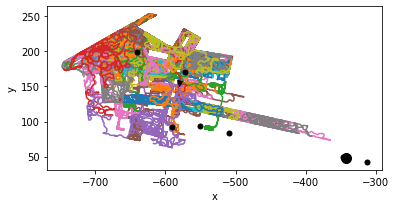

In [57]:
a = np.asarray(positions)

In [59]:
# np.asarray(positions)[0,:,:]
a[:,0,:]

array([[-658.27581787,   -2.00203896,  201.80421448],
       [-692.20007324,   -2.60203886,  134.20001221],
       [-657.69000244,   -2.00203896,  200.38999939],
       [-514.93933105,   -2.25907612,  168.72293091],
       [-587.06671143,   -1.95572376,  206.13334656],
       [-595.00006104,   -2.10203886,  187.7333374 ],
       [-622.01391602,   -2.33537197,  159.40686035],
       [-622.51916504,   -2.34661078,  158.38578796],
       [-537.83898926,   -2.23537207,  170.34942627],
       [-630.05249023,   -2.11247063,  186.31912231]])

In [6]:
# import json
# with open('data.json', 'w') as f:
#     json.dump(positions, f)

# run a2c

In [ ]:
load_prev_model = 'model_latest'
# !!!!!! jtan
# scores, positions = a2c_ppo_acktr(env_info)

# DQN function

In [ ]:
def dqn(env_info, n_episodes=1, max_t=2000, eps_start=1.0, eps_end=0.01, 
        eps_decay=0.995, target_scores=1.0, video_flag=True, load_prev_model=None):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        target_scores (float): average scores aming to achieve, the agent will stop training once 
                            it reaches this scores
        video_flag (boolean): a flag for whether to record video, if set to True, 
                            video would be recorded for every 20 episodes
    
    Returns
    ======
        scores in 2-d array
        positions in 2-d array
    
    """
    # load previous trained result
    if not load_prev_model == None:
        agent.qnetwork_local.load_state_dict(torch.load(load_prev_model))
    
    start = time.time()                       # Start time
    scores = []                               # list containing scores from each episode
    positions = []                            # position list
    scores_window = deque(maxlen=100)         # last 100 scores
    eps = eps_start                           # initialize epsilon
    
    
    width, height, channel = [300, 300, 3]
    
    for i_episode in range(1, n_episodes+1):
        
        video_flag = (i_episode % 20 == 0)
        
        # start video recording 
        if video_flag:
            fourcc = cv2.VideoWriter_fourcc('M','S','V','C') #Microspoft Video 1
            video  = cv2.VideoWriter('output_sep_18_%s.avi' % (str(i_episode)), fourcc, 30, (width, height))
            
        # Reset env and score at the beginning of episode
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment 
        
        # get the current visual state
        state = np.transpose(np.asarray(env_info.visual_observations)[0][0], (2, 0, 1)) 
        
        # initialize the score
        score = 0
        
        # storing temporary path for an episode
        position_epi = []
        
        for t in range(max_t):
            
            if video_flag:
                video.write(np.asarray(env_info.visual_observations)[0][0])
                
            action = agent.act(state, eps)
            
            # translate action variable into forward, rotate, and right
            action_transformed = get_action(action)
            env_info = env.step(action_transformed)[brain_name]        # send the action to the environment
            next_state = np.transpose(np.asarray(env_info.visual_observations)[0][0], 
                                      (2, 0, 1)) # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            
            agent.step(state, action, reward, next_state, done)
            
            state = next_state
            
            score += reward
            
            position_epi.append(env_info.vector_observations[0][-3:].tolist())
            
            stdout.write('\r t:{}, position:{}, score:{:.3f}'.format(str(t), 
                                    str(env_info.vector_observations[0][-3:]), score))
            stdout.flush()
                                
        positions.append(position_epi)
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        print('\nEpisode {}\tAverage Score: {:.2f}\t Last Move {}\n'.format(i_episode, 
                                                        np.mean(scores_window), action_transformed), end="")
        if i_episode % 10 == 0:
            # torch.save(agent.qnetwork_local.state_dict(), 'model_%s' % str(i_episode))
            torch.save(agent.qnetwork_local.state_dict(), 'model_latest')
        
        # add rewards to writer
        writer.add_scalar('total_rewards', score, i_episode)
                
        # if np.mean(scores_window)>=target_scores:
        #     print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, 
        #                                                                      np.mean(scores_window)))
        #     torch.save(agent.qnetwork_local.state_dict(), model_weight_name)
        #     break
        
        if video_flag:
            cv2.destroyAllWindows()
            video.release()
    
    writer.close()

    print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    torch.save(agent.qnetwork_local.state_dict(), model_weight_name)

    time_elapsed = time.time() - start
    print("Time Elapse: {:.2f}".format(time_elapsed))
    
    return scores, positions

# run DQN

In [23]:
load_prev_model = 'model_latest'
scores, positions = dqn(env_info, n_episodes=100, max_t=2000, eps_start=1.0, 
                        eps_end=0.01, eps_decay=0.995, target_scores=1.0,
                        video_flag=False, load_prev_model=load_prev_model)

In [5]:
env_info = env.reset(train_mode=True)[brain_name]

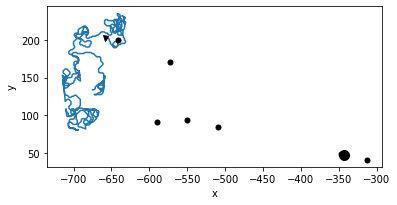

In [29]:
vis_paths(positions, goals, final_goal)

In [16]:
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# point_a = [[1093 - 888, 592 - 394], [1093 - 294, 592 - 92]]
point_a = [[205, 198], [799, 500]]
# point_b = [[-252.8 - 388.5, 118.7 + 80.5], [75.5 - 388.5, -38.7 + 80.5]]
point_b = [[-641.3, -199.2], [-313.0, -41.8]]

a = math.sqrt((point_a[0][0] - point_a[1][0])**2 + (point_a[0][1] - point_a[1][1])**2)
b = math.sqrt((point_b[0][0] - point_b[1][0])**2 + (point_b[0][1] - point_b[1][1])**2)
ratio = a / b
plus = [point_a[0][0] - point_b[0][0] * ratio, point_a[0][1] - point_b[0][1] * ratio]
print(point_b[0][0] * ratio + plus[0], point_b[0][1] * ratio + plus[1])
print(point_b[1][0] * ratio + plus[0], point_b[1][1] * ratio + plus[1])
# print([[i[0] * ratio + , i[i] * ratio + ] for ])

205.0 197.99999999999994
805.8731636688163 486.0823513904103


In [18]:
trans_pos = [np.array([[j[0] * ratio + plus[0], j[1], j[2] * ratio + plus[1]] for j in i]) for i in pos]

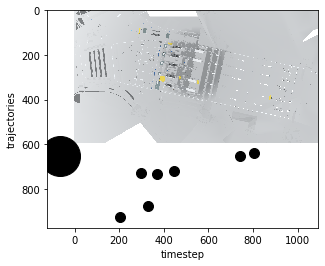

In [20]:
img = mpimg.imread('./plan.png')
plt.imshow(img)

for i in range(len(trans_pos)):
    if i == 11:
        plt.plot(trans_pos[i][:,0], trans_pos[i][:,2])

for i in range(len(goals)):
    plt.plot(goals[i][0]  * ratio + plus[0], goals[i][2]  * ratio + plus[1], marker='o', markersize=10, color="black")

plt.plot([final_goal[0] * ratio + plus[1]], [final_goal[2] * ratio + plus[1]], marker='o', markersize=40, color="black")
plt.xlabel('timestep')
plt.ylabel('trajectories')
plt.show()

In [21]:
imgs = np.expand_dims(np.asarray(env_info.visual_observations)[0][0], axis=0)
input = np.transpose(imgs, (0, 3, 1, 2))
input = np.concatenate([input, input, input, input], 0)
print(input.shape)

m1  = torch.nn.Conv2d(3, 32, kernel_size=8, stride=4)
m2  = torch.nn.Conv2d(32, 64, kernel_size=4, stride=2)
m3  = torch.nn.Conv2d(64, 64, kernel_size=3, stride=1)
fc4 = torch.nn.Linear(34 * 34 * 64, 512)
fc5 = torch.nn.Linear(512, 9)

input = torch.randn(1, 3, 300, 300)
output1 = m1(input)
print(output1.shape)
output2 = m2(output1)
print(output2.shape)
output3 = torch.flatten(m3(output2))
print(output3.shape)
output4 = fc4(output3)
print(output4.shape)
output5 = fc5(output4)

# fc5(fc4(m3(m2(m1(input)))))


(4, 3, 300, 300)
torch.Size([1, 32, 74, 74])
torch.Size([1, 64, 36, 36])
torch.Size([73984])
torch.Size([512])


In [ ]:
input = torch.randn(3, 300, 300)
input = input.unsqueeze(0)

In [ ]:
input.shape

In [ ]:
output5

In [ ]:
plt.imshow(np.asarray(env_info.visual_observations)[0][0])

In [ ]:

# plot the scores
# fig = plt.figure()
# ax = fig.add_subplot(111)
# plt.plot(np.arange(len(scores)), scores)
# plt.ylabel('Score')
# plt.xlabel('Episode #')
# plt.show()

In [ ]:
print(agent.chck[1])

In [ ]:
agent.qnetwork_local(agent.chck[0].unsqueeze(0))

### Watch the agent running ( Using saved weights)

In [ ]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load(model_weight_name))

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score

while True:
    action = agent.act(state)                      # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

### Close Unity ML Environment

In [ ]:
env.close()